In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aiffel-ds-3-house-prices/sample_submission.csv
/kaggle/input/aiffel-ds-3-house-prices/train.csv
/kaggle/input/aiffel-ds-3-house-prices/test.csv


In [2]:
# 필요한 라이브러리 불러오기
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('/kaggle/input/aiffel-ds-3-house-prices/train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


# 데이터 정제

In [3]:
# 데이터 셋 전체 크기와, 컬럼타입, null 있는 컬럼 건수
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1168, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1162
MiscFeature     1120
Alley           1098
Fence            941
MasVnrType       694
FireplaceQu      545
LotFrontage      218
GarageType        69
GarageYrBlt       69
GarageFinish      69
GarageQual        69
GarageCond        69
BsmtFinType2      24
BsmtExposure      24
BsmtFinType1      23
BsmtCond          23
BsmtQual          23
MasVnrArea         8
Electrical         1
dtype: int64


전체 1168 건 

Null 컬럼과 그 건수: PoolQC          1162
MiscFeature     1120
Alley           1098
Fence           

3개는 1000 건이상이 null을 포함
1개 는 941개로 1000에 가까우므로, 해당 컬럼(피쳐) 드랍 진행 941

In [4]:
## 불필요 컬럼 삭제
drop_columns = ['PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu']
house_df.drop(drop_columns, axis=1, inplace=True)

house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    950 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   LotShape       1168 non-null   object 
 7   LandContour    1168 non-null   object 
 8   Utilities      1168 non-null   object 
 9   LotConfig      1168 non-null   object 
 10  LandSlope      1168 non-null   object 
 11  Neighborhood   1168 non-null   object 
 12  Condition1     1168 non-null   object 
 13  Condition2     1168 non-null   object 
 14  BldgType       1168 non-null   object 
 15  HouseStyle     1168 non-null   object 
 16  OverallQual    1168 non-null   int64  
 17  OverallCond    1168 non-null   int64  
 18  YearBuil

In [5]:
house_df.shape

(1168, 76)

타깃값(SalePrice) 이 정규분포인지 확인

치우친 형태 임 ( 아래 )

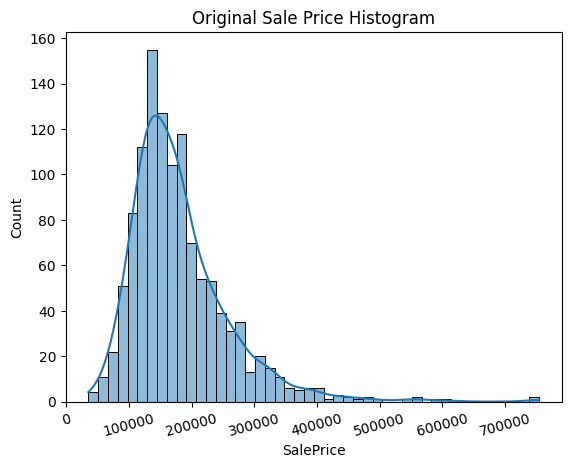

In [6]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

로그 적용 하여 타겟값 확인

정규분포 형태 띔 ( 아래 )

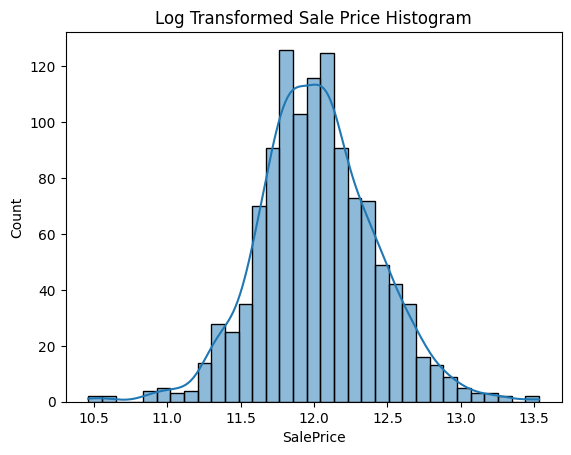

In [7]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

타겟값 ( SalesPrice ) 에 로그적용

In [8]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

그외 null 포함 컬럼 처리

In [9]:
# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
numeric_columns = house_df.select_dtypes(include=['number']).columns
#house_df[numeric_columns] = house_df[numeric_columns].fillna(house_df[numeric_columns].mean())

In [10]:
numeric_columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [11]:
# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
numeric_columns = house_df.select_dtypes(include=['number']).columns
house_df[numeric_columns] = house_df[numeric_columns].fillna(house_df[numeric_columns].mean())

In [12]:
# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

# 데이터 셋 전체 크기와, 컬럼타입, null 있는 컬럼 건수
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object
데이터 세트의 Shape: (1168, 76)

전체 feature 들의 type 
 object     38
int64      34
float64     4
Name: count, dtype: int64

Null 컬럼과 그 건수:
  MasVnrType      694
GarageType       69
GarageFinish     69
GarageQual       69
GarageCond       69
BsmtExposure     24
BsmtFinType2     24
BsmtQual         23
BsmtCond         23
BsmtFinType1     23
Electrical        1
dtype: int64


In [13]:
# get_dummies() 함수로, 원핫 인코딩 수행. null 값을 0... 으로 채움
house_df_ohe = pd.get_dummies(house_df)


In [14]:
house_df_ohe.shape ## 원핫 인코딩 후 컬럼 갯수 늘어남 ( 267 )

(1168, 268)

In [15]:
null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

## null 처리 완료

## Null 피처의 Type :
 Series([], dtype: object)


# 선형 모델 학습/예측/평가

평가지표 : RMSE

SalesePrice가 현재 로그 변환 되어 있음 .

In [16]:
## RMSE 반환 함수 생성
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [17]:
## 모델 학습 / 예측 / 평가
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.131
Ridge 로그 변환된 RMSE: 0.132
Lasso 로그 변환된 RMSE: 0.177


[0.13096548839891198, 0.13246727669757738, 0.17727257419179054]

Lasso 가 다른 회귀 방식 보다 높은 편 . 1.77

피쳐별 회귀 계수 시각화 - 모델별 어떤 피쳐를 활용하여 회귀 계수를 작성했는지 확인.

In [18]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low
# end of get_top_bottom_coef

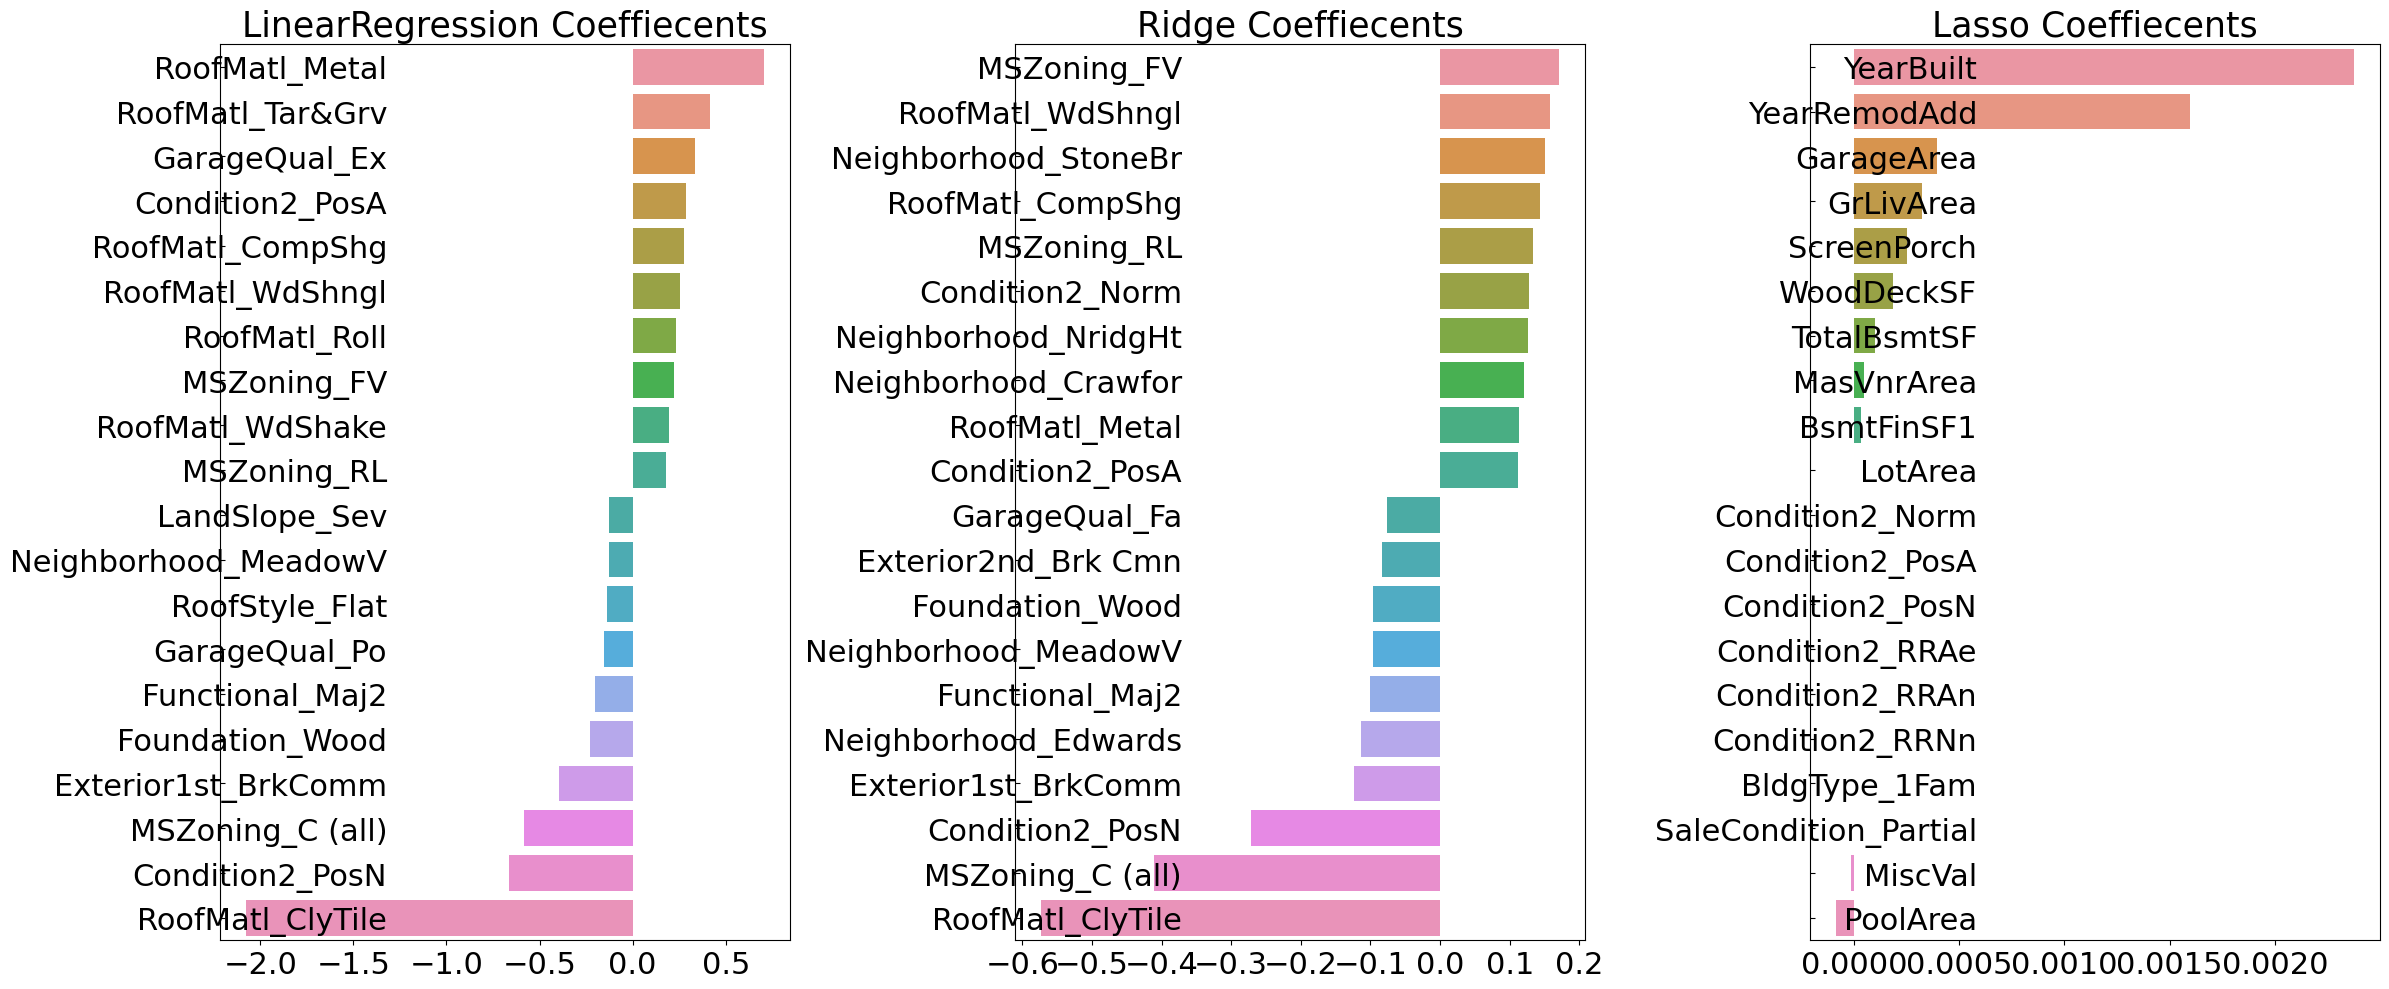

In [19]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])
# end of visualize_coefficient

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)
plt.tight_layout()

Lasso는 건축 연도를 많이 참조 함. 다른 회귀 계수 너무 축소 시킴.

선형회귀와 릿지는 유사한 회귀계수 형태.


테스트 데이터 분할 문제인지 확인 하기 -> y_target을 5개 교차검증 폴드로 분할 해 평균 RMSE 측정해보기

In [20]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))
# end of get_avg_rmse_cv

# 앞서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.247 0.196 0.111 0.129 0.116]
LinearRegression CV 평균 RMSE 값: 0.16

Ridge CV RMSE 값 리스트: [0.213 0.172 0.12  0.131 0.119]
Ridge CV 평균 RMSE 값: 0.151

Lasso CV RMSE 값 리스트: [0.287 0.212 0.173 0.185 0.17 ]
Lasso CV 평균 RMSE 값: 0.205


LinearRegression 제외 하겠음

5개 폴드 분할 학습 평균도 라쏘가 릿지에 비해 성능 떨어 짐.

## 최적 파라미터 확인하기

In [21]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_
# end of print_best_params

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1509, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.152, 최적 alpha:{'alpha': 0.001}


라쏘 의 경우 최적 적용 시 0.205 -> 0.152 로 향상 됨

최적파라미터 적용 하여, 학습/테스트 예측 평가 수행

LinearRegression 로그 변환된 RMSE: 0.131
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.122


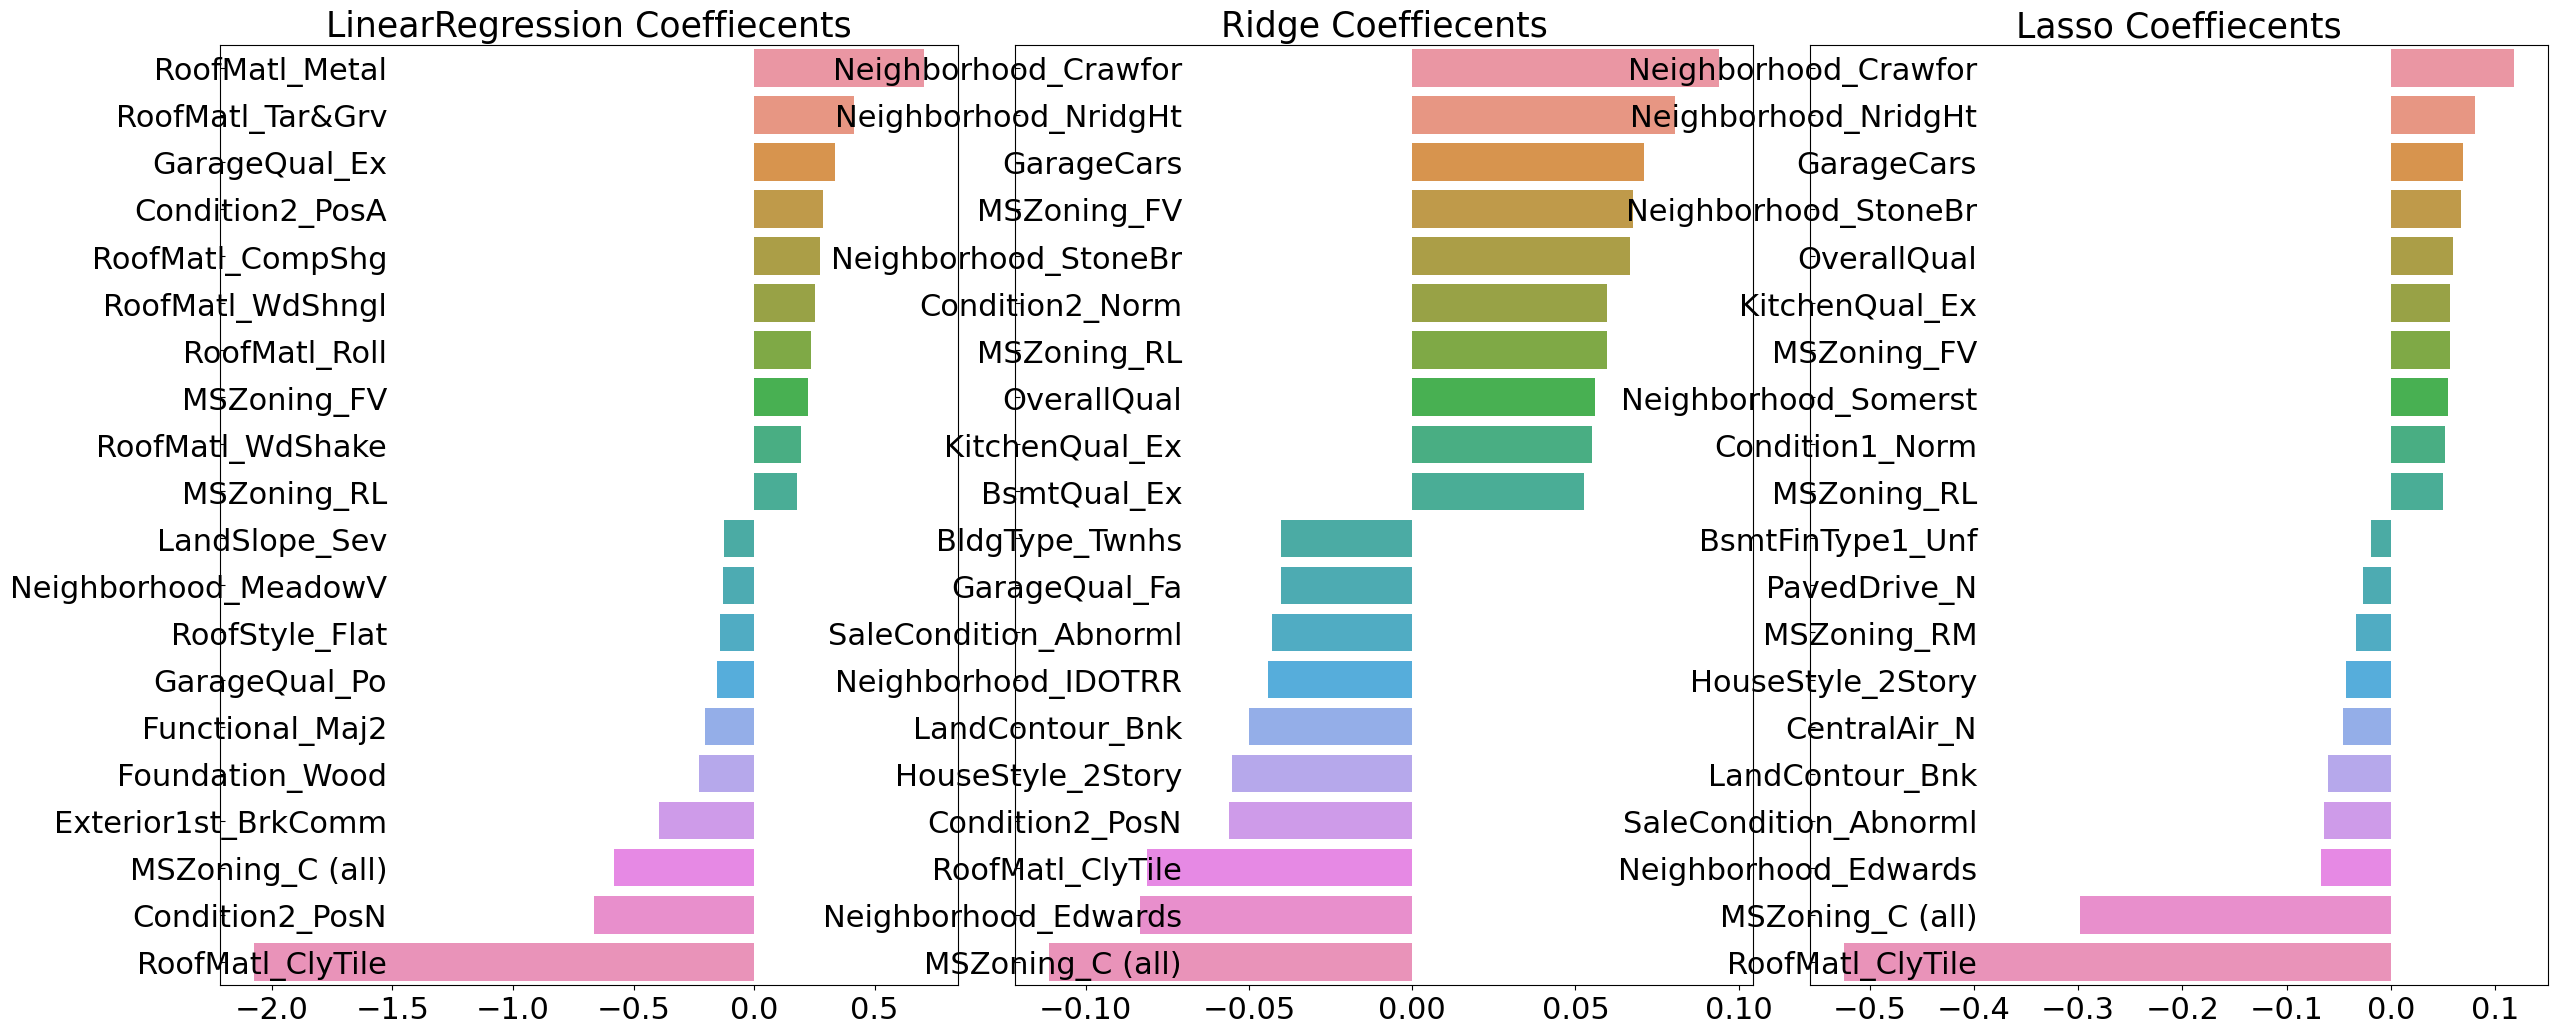

In [22]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [23]:
### 1 차 학습

# * LinearRegression 로그 변환된 RMSE: 0.131
# * Ridge		 로그 변환된 RMSE: 0.132
# * Lasso		 로그 변환된 RMSE: 0.177


### 최적 파라미터 적용 후

# * LinearRegression 로그 변환된 RMSE: 0.131
# * Ridge		 로그 변환된 RMSE: 0.128
# * Lasso		 로그 변환된 RMSE: 0.122

##### 최적 파라미터 적용 후 : 릿지, 라쏘 모두 성능 개선 확인
##### 모델 회귀 계수 달라짐 : 릿지, 라쏘 모두 활용 피쳐 비슷 해짐

타겟은 이미 로그적용, 정규분포 확인하였으며,

피쳐 중 왜곡 된 값이 있는지 확인 하고, 처리 하도록 함.


scipy.stats 의 skew 객체 활용
- 반환값이 1 이상인 경우를 왜곡 정도가 높다 판단 함.
- 1이상인 피처만 추출하여, 왜곡 완화 위해 로그변환 적용.
- 원핫인코딩 된 카테고리형 숫자형 피쳐는 제외
- 원핫인코딩 적용 되지 않은 house_df 활용

In [24]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew( ) 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          22.099034
PoolArea         14.377604
LotArea          11.097791
3SsnPorch        11.040646
LowQualFinSF      9.608861
BsmtFinSF2        4.507199
KitchenAbvGr      4.488325
BsmtHalfBath      4.133732
ScreenPorch       3.976766
EnclosedPorch     3.093917
LotFrontage       2.760540
OpenPorchSF       2.454159
MasVnrArea        2.418589
BsmtFinSF1        1.881057
TotalBsmtSF       1.864686
WoodDeckSF        1.546567
1stFlrSF          1.488257
GrLivArea         1.474257
MSSubClass        1.391605
dtype: float64


In [25]:
## 왜곡 정도가 높은 컬럼들 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [26]:
# 왜곡 정도 다시 확인 
# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew( ) 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

PoolArea         13.856300
3SsnPorch         8.028782
LowQualFinSF      7.993707
MiscVal           4.894006
BsmtHalfBath      3.930833
KitchenAbvGr      3.749927
ScreenPorch       3.056219
BsmtFinSF2        2.610665
EnclosedPorch     2.087957
dtype: float64


많이 개선됨. 일부 남아 있으나 이대로 진행 하겠음.


왜곡 피쳐들의 왜곡을 완화 한 house_df 로 다시 원핫 인코딩 수행. 
타깃, 피쳐, 학습, 테스트 데이터 다시 생성 함

In [27]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [28]:
# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1332, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1296, 최적 alpha:{'alpha': 0.001}


In [29]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.001)

In [30]:
# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)


LinearRegression 로그 변환된 RMSE: 0.124
Ridge 로그 변환된 RMSE: 0.116
Lasso 로그 변환된 RMSE: 0.111


[0.12431509709874194, 0.11571008386335059, 0.11103267521503735]

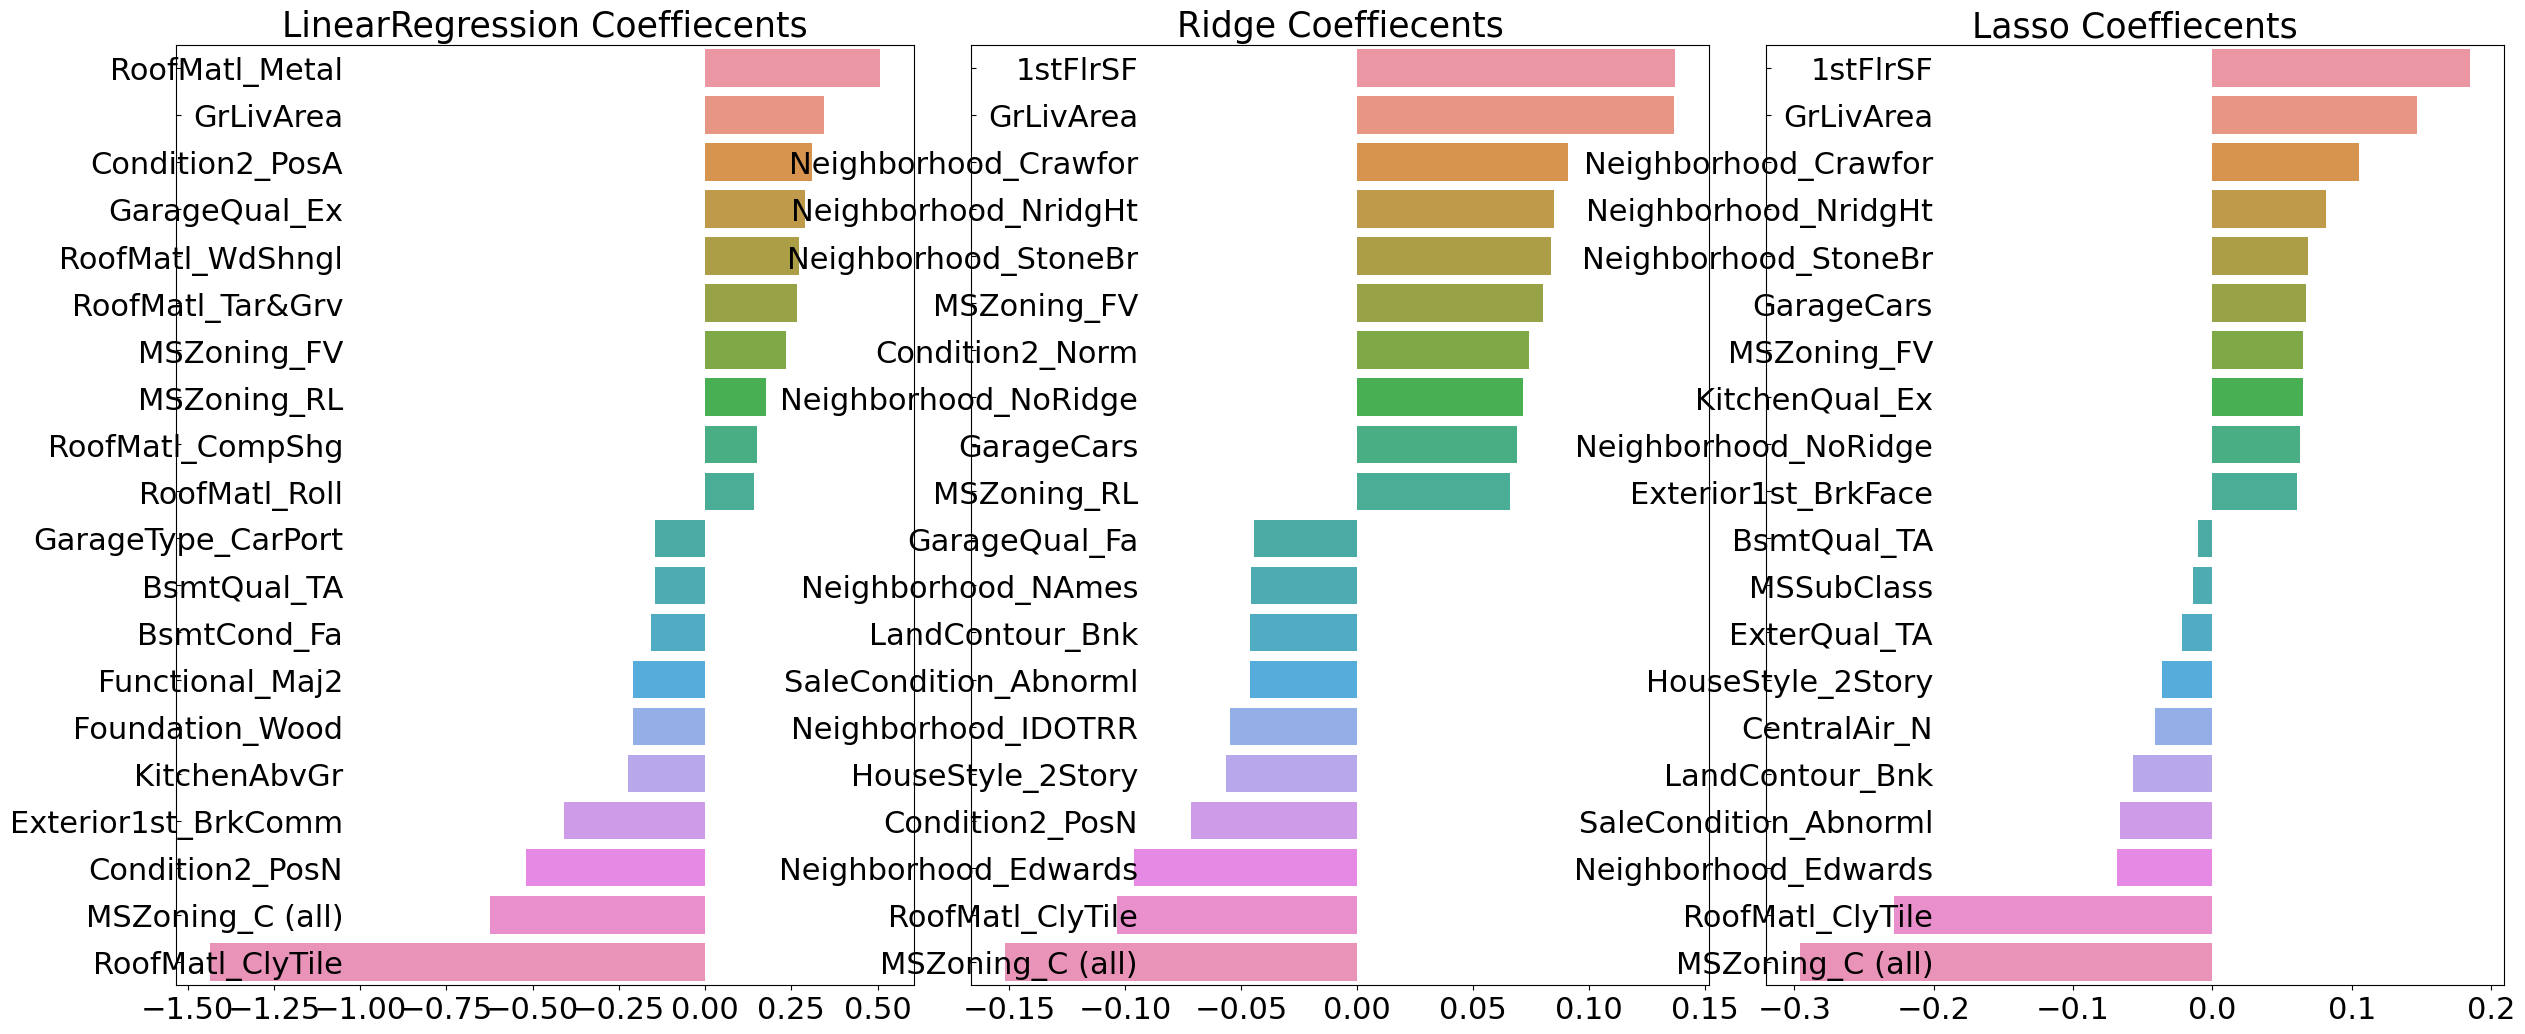

In [31]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [32]:
# target SalesPrice 의 log 적용 후

# 1 차 학습
# LinearRegression 로그 변환된 RMSE: 0.131
# Ridge		 로그 변환된 RMSE: 0.132
# Lasso		 로그 변환된 RMSE: 0.177
# [0.13096484089029303, 0.1324937393212141, 0.1772725785995742]


# 도출된 최적 파라미터
# Ridge 5 CV 시 최적 평균 RMSE 값: 0.1509, 최적 alpha:{'alpha': 12}
# Lasso 5 CV 시 최적 평균 RMSE 값: 0.152, 최적 alpha:{'alpha': 0.001}

# 최적 파라미터 적용 후
# LinearRegression 로그 변환된 RMSE: 0.131
# Ridge		 로그 변환된 RMSE: 0.128
# Lasso		 로그 변환된 RMSE: 0.122


# 피처 왜곡 완화 후 최적 파라미터
# Ridge 5 CV 시 최적 평균 RMSE 값: 0.1332, 최적 alpha:{'alpha': 8}
# Lasso 5 CV 시 최적 평균 RMSE 값: 0.1296, 최적 alpha:{'alpha': 0.001}


# 피처 왜곡 완화 후 최적 파라미터 적용 후
# LinearRegression 로그 변환된 RMSE: 0.124
# Ridge		 로그 변환된 RMSE: 0.116
# Lasso		 로그 변환된 RMSE: 0.111

피쳐 왜곡 완화 후 최적 파라미터 적용 후 모든 모델 성능 향상 확인.

회귀계수 가장 높은 피쳐는 1층 면적크기와, 주거공간 크기로 변경 됨.

면적에 집값이 비례 한다는 타당한 결과 도출 됨.

## 이상치 데이터 확인
가장 큰 회귀계수인  1stFlrSF / GrLivArea 확인 해보기

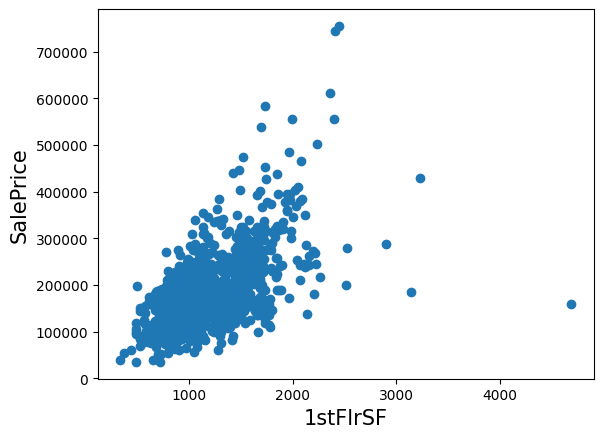

In [33]:
## 1stFlrSF / SalesPrice 관계 시각화

plt.scatter(x = house_df_org['1stFlrSF'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('1stFlrSF', fontsize=15)
plt.show()

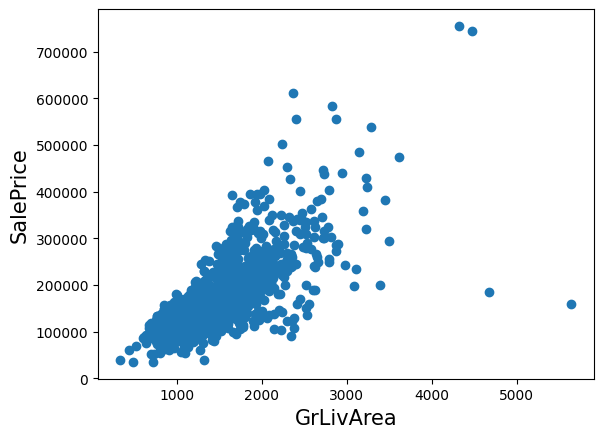

In [34]:
## GrLivArea / SalesPrice 관계 시각화

plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

두 피처 다. 면적에 관련된 것이며, 면적이 넓은데, 가격이 낮은 이상치 2건이 있다.**

1stFlrSF 기준으로 이상치 처리 해보겠음.

In [35]:
# 1stFlrSF SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성. 
cond1 = house_df_ohe['1stFlrSF'] > np.log1p(3000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(200000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index : [ 64 373]
아웃라이어 삭제 전 house_df_ohe shape: (1168, 268)


In [36]:
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제. 
house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 삭제 후 house_df_ohe shape: (1166, 268)


이상치 삭제 후 테이터 세트 다시 생성

In [37]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

릿지와 라쏘 모델 최적화 다시 수행

In [38]:
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1149, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1132, 최적 alpha:{'alpha': 0.001}


In [39]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=5)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.121
Ridge 로그 변환된 RMSE: 0.116
Lasso 로그 변환된 RMSE: 0.112


[0.12144359631730216, 0.11630433023541478, 0.1120075995669598]

In [ ]:
# target SalesPrice 의 log 적용 후

# 1 차 학습
# LinearRegression 로그 변환된 RMSE: 0.131
# Ridge		 로그 변환된 RMSE: 0.132
# Lasso		 로그 변환된 RMSE: 0.177
# [0.13096484089029303, 0.1324937393212141, 0.1772725785995742]


# 도출된 최적 파라미터
# Ridge 5 CV 시 최적 평균 RMSE 값: 0.1509, 최적 alpha:{'alpha': 12}
# Lasso 5 CV 시 최적 평균 RMSE 값: 0.152, 최적 alpha:{'alpha': 0.001}

# 최적 파라미터 적용 후
# LinearRegression 로그 변환된 RMSE: 0.131
# Ridge		 로그 변환된 RMSE: 0.128
# Lasso		 로그 변환된 RMSE: 0.122


# 피처 왜곡 완화 후 최적 파라미터
# Ridge 5 CV 시 최적 평균 RMSE 값: 0.1332, 최적 alpha:{'alpha': 8}
# Lasso 5 CV 시 최적 평균 RMSE 값: 0.1296, 최적 alpha:{'alpha': 0.001}


# 피처 왜곡 완화 후 최적 파라미터 적용 후
# LinearRegression 로그 변환된 RMSE: 0.124
# Ridge		 로그 변환된 RMSE: 0.116
# Lasso		 로그 변환된 RMSE: 0.111


# 이상치 삭제 후 최적 파라미터
# Ridge 5 CV 시 최적 평균 RMSE 값: 0.1149, 최적 alpha:{'alpha': 5}
# Lasso 5 CV 시 최적 평균 RMSE 값: 0.1132, 최적 alpha:{'alpha': 0.001}

# 이상치 삭제 후 최적 파라미터 적용 후
# LinearRegression 로그 변환된 RMSE: 0.121
# Ridge		 로그 변환된 RMSE: 0.116
# Lasso		 로그 변환된 RMSE: 0.112SE: 0.116
Lasso		 로그 변환된 RMSE: 0.112

In [40]:

# 이상치 삭제 후 최적 파라미터 적용 후


# - LinearRegression 로그 변환된 RMSE: 0.121
# - Ridge		 로그 변환된 RMSE: 0.116
# - Lasso		 로그 변환된 RMSE: 0.112



# 위 결과를 바탕으로, 선형회귀는 성능 좋아짐. 릿지 변화 없음. 라쏘는 0.001 안좋아졌음. 수용하기로 함.

In [41]:
pred_lasso = lasso_reg.predict(X_test)

In [42]:
X_test

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
857,318,4.110874,4.330733,9.105091,8,5,2006,2006,0.000000,0.000000,...,False,False,False,True,False,False,False,False,True,False
575,1259,4.394449,4.094345,9.168268,7,5,2005,2005,5.209486,6.486161,...,False,False,False,True,False,False,False,False,True,False
672,72,3.044522,4.248495,8.935904,4,6,1982,2006,0.000000,6.338594,...,False,False,False,True,False,False,False,False,True,False
942,1066,4.110874,4.394449,9.546884,7,5,1996,1997,0.000000,7.091742,...,False,False,False,True,False,False,False,False,True,False
826,1433,3.433987,4.110874,9.287394,4,6,1927,2007,0.000000,0.000000,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,491,5.081404,4.263510,7.888335,5,6,1976,1976,0.000000,0.000000,...,False,False,False,True,False,False,False,False,True,False
358,741,4.262680,4.110874,9.169623,5,7,1910,2002,0.000000,0.000000,...,False,False,False,True,True,False,False,False,False,False
259,55,4.394449,4.110874,8.872768,5,5,1955,1955,0.000000,5.953243,...,False,False,False,True,False,False,False,False,True,False
967,470,4.110874,4.343805,9.136909,6,5,1993,1993,4.795791,6.056784,...,False,False,False,True,False,False,False,False,True,False


In [50]:
pred = lasso_reg.predict(X_test)

In [53]:
X_test

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
857,318,4.110874,4.330733,9.105091,8,5,2006,2006,0.000000,0.000000,...,False,False,False,True,False,False,False,False,True,False
575,1259,4.394449,4.094345,9.168268,7,5,2005,2005,5.209486,6.486161,...,False,False,False,True,False,False,False,False,True,False
672,72,3.044522,4.248495,8.935904,4,6,1982,2006,0.000000,6.338594,...,False,False,False,True,False,False,False,False,True,False
942,1066,4.110874,4.394449,9.546884,7,5,1996,1997,0.000000,7.091742,...,False,False,False,True,False,False,False,False,True,False
826,1433,3.433987,4.110874,9.287394,4,6,1927,2007,0.000000,0.000000,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,491,5.081404,4.263510,7.888335,5,6,1976,1976,0.000000,0.000000,...,False,False,False,True,False,False,False,False,True,False
358,741,4.262680,4.110874,9.169623,5,7,1910,2002,0.000000,0.000000,...,False,False,False,True,True,False,False,False,False,False
259,55,4.394449,4.110874,8.872768,5,5,1955,1955,0.000000,5.953243,...,False,False,False,True,False,False,False,False,True,False
967,470,4.110874,4.343805,9.136909,6,5,1993,1993,4.795791,6.056784,...,False,False,False,True,False,False,False,False,True,False


In [54]:
# # X_test의 `Id`를 가지고 오고 예측 결과를 DataFrame으로.
# ids = X_test['Id']
# predictions = pd.Series(pred_lasso, name='SalePrice')

# # 두 시리즈를 결합하여 DataFrame 생성
# output_df = pd.DataFrame({'Id': ids, 'SalePrice': predictions})

# output_df.to_csv('submission.csv', index=False)






# 'Amount_Scaled' 열을 train 데이터에서 계산한 방식대로 test 데이터에 추가

# 학습 데이터에서 사용한 열만 선택
train_columns = X_train.columns

# test 데이터에서 train 데이터에 있는 피처만 선택
test_selected = X_test[train_columns]

# 테스트 데이터에 대해 확률 예측
y_pred_proba_test = lasso_reg.predict(X_test)

# 제출 파일 생성 (id 열과 예측값을 포함)
submission = pd.DataFrame({'Id': X_test['Id'], 'SalePrice': y_pred_proba_test})

# 제출 파일을 CSV로 저장
submission.to_csv('submission.csv', index=False)


# 트리모델 학습/예측/평가

In [44]:
# from xgboost import XGBRegressor

# xgb_params = {'n_estimators':[1000]}
# xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
#                        colsample_bytree=0.5, subsample=0.8)
# best_xgb = print_best_params(xgb_reg, xgb_params)

In [45]:
# from lightgbm import LGBMRegressor

# lgbm_params = {'n_estimators':[1000]}
# lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
#                          subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
# best_lgbm = print_best_params(lgbm_reg, lgbm_params)

In [46]:
# from sklearn.ensemble import RandomForestRegressor

# rf_params = {'n_estimators':[1000]}

# rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
# best_xgb = print_best_params(rf_reg, rf_params)

# 회고

0. 최대한 책에 나온 흐름을 따라, 의미를 파악하며 진행 함.
1. 처음 접한 머신러닝 개발의 각 단계 데이터 형태를 알지 못하는 현 상황을 인지 함.
2. 각 단계별 데이터 형태를 찍어가며, 어떻게 데이터가 바뀌는지 알아야 할 필요를 느낌. ( 주말 추가 심화 학습 필요 )
3. 왜 submission.csv 를 찾지 못하는지 서치 하고 있으나, 해결 되지 않음.
4. 파일 내부의 형태의 문제라면, 결국 각 단계의 데이터 상황을 모르고 진행하는 나에게 문제 있음으로 결론 내림.   